# Imports

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Functions / Calc Column Defs
This code is pillaged from project #1 to allow my calculated columns to be config instead of hardcoded

In [146]:
# Calculated column definitions. These will be applied AFTER data cleansing, once dfClean (the clean dataset) is created
dictCalculatedColData = {
    # Example of a lookup, i.e. the value in new column "transaction fee" is based on the values in the "payment method" column
    "ConsoleGeneration": # Column to be created
        {
            "Column Type": "Lookup",
            "Data Type": "int64[pyarrow]",
            "Column Spec":
            {
                "Platform": # Column containing the categories we need to look up
                {
                    "2600": 2,
                    "3DS": 8,
                    "DC": 6,
                    "DS": 7,
                    "GB": 4,
                    "GBA": 6,
                    "GBC": 5,
                    "GC": 6,
                    "GEN": 4,
                    "N64": 5,
                    "NES": 3,
                    "NS": 8,
                    "PS": 5,
                    "PS2": 6,
                    "PS3": 7,
                    "PS4": 8,
                    "PSP": 7,
                    "PSV": 8,
                    "SAT": 5,
                    "SCD": 4,
                    "SNES": 4,
                    "Wii": 7,
                    "WiiU": 8,
                    "X360": 7,
                    "XB": 6,
                    "XOne": 8
                }
            }
        },
    "ConsoleManufacturer": # Column to be created
        {
            "Column Type": "Lookup",
            "Data Type": "string[pyarrow]",
            "Column Spec":
            {
                "Platform": # Column containing the categories we need to look up
                {
                    "2600": "Atari",
                    "3DS": "Nintendo",
                    "DC": "Sega",
                    "DS": "Nintendo",
                    "GB": "Nintendo",
                    "GBA": "Nintendo",
                    "GBC": "Nintendo",
                    "GC": "Nintendo",
                    "GEN": "Sega",
                    "N64": "Nintendo",
                    "NES": "Nintendo",
                    "NS": "Nintendo",
                    "PS": "Sony",
                    "PS2": "Sony",
                    "PS3": "Sony",
                    "PS4": "Sony",
                    "PSP": "Sony",
                    "PSV": "Sony",
                    "SAT": "Sega",
                    "SCD": "Sega",
                    "SNES": "Nintendo",
                    "Wii": "Nintendo",
                    "WiiU": "Nintendo",
                    "X360": "Microsoft",
                    "XB": "Microsoft",
                    "XOne": "Microsoft"
                }
            }
        },
    "PublisherType": # Column to be created
        {
            "Column Type": "2ColLookup",
            "Data Type": "string[pyarrow]",
            "Column Spec":
            {
                ("ConsoleManufacturer", "Publisher"): # Column containing the categories we need to look up
                {
                    ("Atari", "Atari"): "First Party",
                    ("Microsoft", "Microsoft"): "First Party",
                    ("Microsoft", "Microsoft Game Studios"): "First Party",
                    ("Microsoft", "Microsoft Studios"): "First Party",
                    ("Microsoft", "Mojang"): "First Party",
                    ("Nintendo", "Nintendo"): "First Party",
                    ("Sega", "Sega"): "First Party",
                    ("Sony", "Sony Computer Entertainment"): "First Party",
                    ("Sony", "Sony Computer Entertainment America"): "First Party",
                    ("Sony", "Sony Interactive Entertainment"): "First Party",
                    ("Sony", "Sony Online Entertainment"): "First Party",
                    ("DEFAULT_VALUE", "DEFAULT_VALUE"): "Third Party"
                }
            }
        }#,
    # Example of a column calculated based on other column values
    # "Total Transaction Fee": 
    # {
    #     "Column Type": "Function",
    #     "Data Type": "double[pyarrow]",
    #     "Column Spec": lambda row: round(row["Transaction Amount"] * row["Transaction Fee Pct"], 2)
    # },

    # # Another calculated column - notice that since we are going to end up applying these in order,
    # # column definitions can reference earlier columns.
    # "Total Transaction Amt": 
    # {
    #     "Column Type": "Function",
    #     "Data Type": "double[pyarrow]",
    #     "Column Spec": lambda row: round(row["Transaction Amount"] + row["Total Transaction Fee"], 2)
    # }
}

# Function to apply calculated columns
def calculated_columns(row, calc_col_def):
    # Get the calculation type from the column definition
    calc_col_type = calc_col_def["Column Type"]

    if calc_col_type == "Lookup":
        # Extract the key and value (which is our lookup dictionary) from calc_col_def
        for base_col_name, dictLookup in calc_col_def["Column Spec"].items():
            if row[base_col_name] in dictLookup:
                return dictLookup[row[base_col_name]]
            elif "DEFAULT_VALUE" in dictLookup:
                return dictLookup["DEFAULT_VALUE"]
            else:
                return None

    if calc_col_type == "2ColLookup":
            lookup_spec = calc_col_def["Column Spec"]
            # There should be exactly one item in Column Spec
            ((col1, col2), lookup_dict) = next(iter(lookup_spec.items()))

            # Create a tuple from the row values
            row_tuple = (row[col1], row[col2])
            
            # Print the row tuple for debugging
            #print("Row tuple:", row_tuple)
            
            # Check if the row tuple exists in the lookup dictionary
            if row_tuple in lookup_dict:
                #print("Key found:", row_tuple)
                return lookup_dict[row_tuple]
            
            # Check for default value
            if ("DEFAULT_VALUE", "DEFAULT_VALUE") in lookup_dict:
                #print("Returning default value")
                return lookup_dict[("DEFAULT_VALUE", "DEFAULT_VALUE")]
            
            # If no match is found, return None
            #print("No match found, returning None")
            return None

    # Default - i.e. the calculated column is of a type we have not written code to handle yet
    else:
        return None

# Read CSV File / Filter Dataframe

In [147]:
# Import the CSV file
df = pd.read_csv("https://raw.githubusercontent.com/candersen114/Python2Source/main/vgsales_new_final.csv", dtype_backend="pyarrow")

print(df.dtypes)

# Remove PC and PSN games, there aren't many and they aren't easily classified into generations
df = df[(df["Platform"] != "PSN") & (df["Platform"] != "PC")]

# Trim publisher and Genre to ensure standardization
df["Genre"] = df["Genre"].str.strip()
df["Publisher"] = df["Publisher"].str.strip()

df.describe(include="all")

Rank             int64[pyarrow]
Name            string[pyarrow]
Platform        string[pyarrow]
Year             int64[pyarrow]
Genre           string[pyarrow]
Publisher       string[pyarrow]
Developer       string[pyarrow]
Critic_Score    double[pyarrow]
User_Score      double[pyarrow]
NA_Sales        double[pyarrow]
PAL_Sales       double[pyarrow]
JP_Sales        double[pyarrow]
Other_Sales     double[pyarrow]
Global_Sales    double[pyarrow]
dtype: object


,Rank,Name,Platform,Year,Genre,Publisher,Developer,Critic_Score,User_Score,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Global_Sales
count,1936.0,1936,1936,1936.0,1936,1936,1936,1098.0,129.0,1878.0,1871.0,1306.0,1905.0,1936.0
unique,<NA>,1528,26,<NA>,17,103,456,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
top,<NA>,Minecraft,PS2,<NA>,Sports,Nintendo,Nintendo EAD,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
freq,<NA>,7,300,<NA>,293,345,69,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
mean,999.905475,NaN,NaN,2005.707645,NaN,NaN,NaN,8.117942,8.834109,1.499989,0.92016,0.573124,0.293433,3.019613
std,578.801568,NaN,NaN,7.538652,NaN,NaN,NaN,1.082233,1.05819,2.046652,1.338663,0.944822,0.501566,3.84032
min,1.0,NaN,NaN,1977.0,NaN,NaN,NaN,2.6,3.0,0.01,0.0,0.0,0.0,1.11
25%,496.75,NaN,NaN,2001.0,NaN,NaN,NaN,7.6,8.5,0.66,0.34,0.04,0.09,1.4
50%,1001.5,NaN,NaN,2007.0,NaN,NaN,NaN,8.3,9.1,1.0,0.56,0.16,0.17,1.895
75%,1499.25,NaN,NaN,2011.0,NaN,NaN,NaN,8.9,9.5,1.65,1.05,0.74,0.32,3.12


## Results
- The fact that all of our categorical data columns (rank, name, platform, year, genre, publisher, developer) have a count of 2000 is very promising - means no missing values in those columns
- Looks like some sales numbers are missing in certain regions. For some of this analysis, I think I'll want to create a subset that only looks at games available in North America and Japan.
- Japan is the video game capital of the world but seems to have fewer sales - probably because it's a smaller country. This means caution (and possibly "grading on a curve") will be needed when comparing results.
    - NA population in 2016 579 million
    - Japan population in 2016 roughly 127 million
    - This means that if there is a need to normalize comparisons between NA and Japan, Japanese sales figures can be multiplied x4.56
- PC and PSN games are included - they are not easily classified into generations. We'll exclude them because the numbers are very low.

# Calculated Columns

In [148]:
# Utilize dictCalculatedColData to apply our calculated columns
for calc_col_name, calc_col_def in dictCalculatedColData.items():
    print("Creating column ", calc_col_name)
    df[calc_col_name] = df.apply(calculated_columns, args=(calc_col_def,), axis=1)
    print("Applying data type ", calc_col_def["Data Type"], " to column ", calc_col_name)
    df[calc_col_name] = df[calc_col_name].astype(calc_col_def["Data Type"])

# Re-output dataframe statistics and sample data to ensure data cleansing was successful
print(df.dtypes)
display(df)
df.describe(include="all")
df.info()

Creating column  ConsoleGeneration
Applying data type  int64[pyarrow]  to column  ConsoleGeneration
Creating column  ConsoleManufacturer
Applying data type  string[pyarrow]  to column  ConsoleManufacturer
Creating column  PublisherType
Applying data type  string[pyarrow]  to column  PublisherType
Rank                    int64[pyarrow]
Name                   string[pyarrow]
Platform               string[pyarrow]
Year                    int64[pyarrow]
Genre                  string[pyarrow]
Publisher              string[pyarrow]
Developer              string[pyarrow]
Critic_Score           double[pyarrow]
User_Score             double[pyarrow]
NA_Sales               double[pyarrow]
PAL_Sales              double[pyarrow]
JP_Sales               double[pyarrow]
Other_Sales            double[pyarrow]
Global_Sales           double[pyarrow]
ConsoleGeneration       int64[pyarrow]
ConsoleManufacturer    string[pyarrow]
PublisherType          string[pyarrow]
dtype: object


,Rank,Name,Platform,Year,Genre,Publisher,Developer,Critic_Score,User_Score,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Global_Sales,ConsoleGeneration,ConsoleManufacturer,PublisherType
0,1,Wii Sports,Wii,2006,Sports,Nintendo,Nintendo EAD,7.7,<NA>,41.36,29.02,3.77,8.51,82.65,7,Nintendo,First Party
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,Nintendo EAD,10.0,8.2,29.08,3.58,6.81,0.77,40.24,3,Nintendo,First Party
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,Nintendo EAD,8.2,9.1,15.91,12.92,3.8,3.35,35.98,7,Nintendo,First Party
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,Nintendo EAD,8.0,8.8,15.61,10.99,3.29,3.02,32.9,7,Nintendo,First Party
4,5,Pokémon Red / Green / Blue Version,GB,1998,Role-Playing,Nintendo,Game Freak,9.4,<NA>,11.27,8.89,10.22,1.0,31.37,4,Nintendo,First Party
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,Red Dead Redemption: Undead Nightmare,X360,2010,Action,Rockstar Games,Rockstar San Diego,10.0,<NA>,0.61,0.38,0.02,0.1,1.11,7,Microsoft,Third Party
1996,1997,Metal Gear Solid HD Collection,PS3,2011,Action,Konami Digital Entertainment,Bluepoint Games,<NA>,<NA>,0.52,0.44,<NA>,0.14,1.11,7,Sony,Third Party
1997,1998,EA Sports UFC,PS4,2014,Fighting,Electronic Arts,EA Canada,<NA>,<NA>,0.49,0.43,0.01,0.18,1.11,8,Sony,Third Party
1998,1999,NCAA Football 13,X360,2012,Sports,EA Sports,EA Tiburon,7.5,<NA>,1.02,<NA>,<NA>,0.09,1.11,7,Microsoft,Third Party


<class 'pandas.core.frame.DataFrame'>
Index: 1936 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Rank                 1936 non-null   int64[pyarrow] 
 1   Name                 1936 non-null   string[pyarrow]
 2   Platform             1936 non-null   string[pyarrow]
 3   Year                 1936 non-null   int64[pyarrow] 
 4   Genre                1936 non-null   string[pyarrow]
 5   Publisher            1936 non-null   string[pyarrow]
 6   Developer            1936 non-null   string[pyarrow]
 7   Critic_Score         1098 non-null   double[pyarrow]
 8   User_Score           129 non-null    double[pyarrow]
 9   NA_Sales             1878 non-null   double[pyarrow]
 10  PAL_Sales            1871 non-null   double[pyarrow]
 11  JP_Sales             1306 non-null   double[pyarrow]
 12  Other_Sales          1905 non-null   double[pyarrow]
 13  Global_Sales         19

# Statistical Analysis

## Total Global Sales Distribution
Purpose: Determine if there are steep drop-offs in sales numbers... i.e. are high-sellers 1% of the data, 10%, 50%, etc.

/var/folders/cx/t4tmn45j49qdssz1t2jr1xwm0000gn/T/ipykernel_4169/1310272597.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ticks)


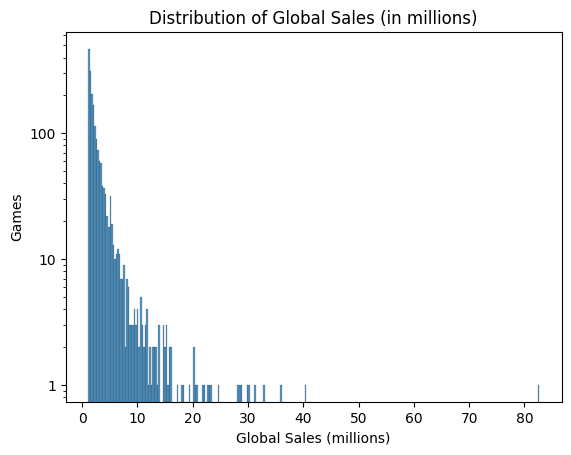

In [152]:
ax = sns.histplot(data=df, x="Global_Sales")
ax.set_title("Distribution of Global Sales (in millions)")
ax.set_xlabel("Global Sales (millions)")
ax.set_yscale("log")
ax.set_ylabel("Games")

# Set Y ticks (logarithmic)
ticks=[pow(10, -2), pow(10, -1), pow(10, 0), pow(10, 1), pow(10, 2), pow(10, 3), pow(10, 4)]
ax.set_yticklabels(ticks)

plt.show()

/var/folders/cx/t4tmn45j49qdssz1t2jr1xwm0000gn/T/ipykernel_4169/2372089091.py:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xbound(lower=0)
/var/folders/cx/t4tmn45j49qdssz1t2jr1xwm0000gn/T/ipykernel_4169/2372089091.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ticks)


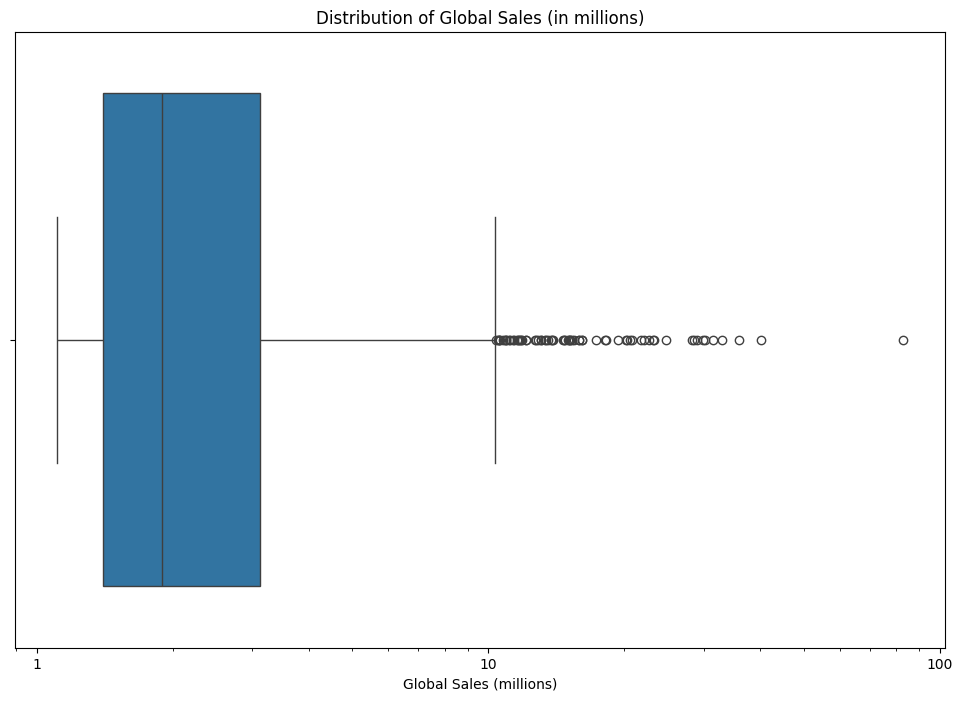

In [150]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df, x="Global_Sales", log_scale=10)

# Set the X bound and tick labels to avoid 10^1, 10^2, etc
ax.set_xbound(lower=0)
ticks=[pow(10, -2), pow(10, -1), pow(10, 0), pow(10, 1), pow(10, 2), pow(10, 3), pow(10, 4)]
ax.set_xticklabels(ticks)

# Titles
ax.set_title("Distribution of Global Sales (in millions)")
ax.set_xlabel("Global Sales (millions)")

# Show Plot
plt.show()

## Games in Generation vs. Global Sales

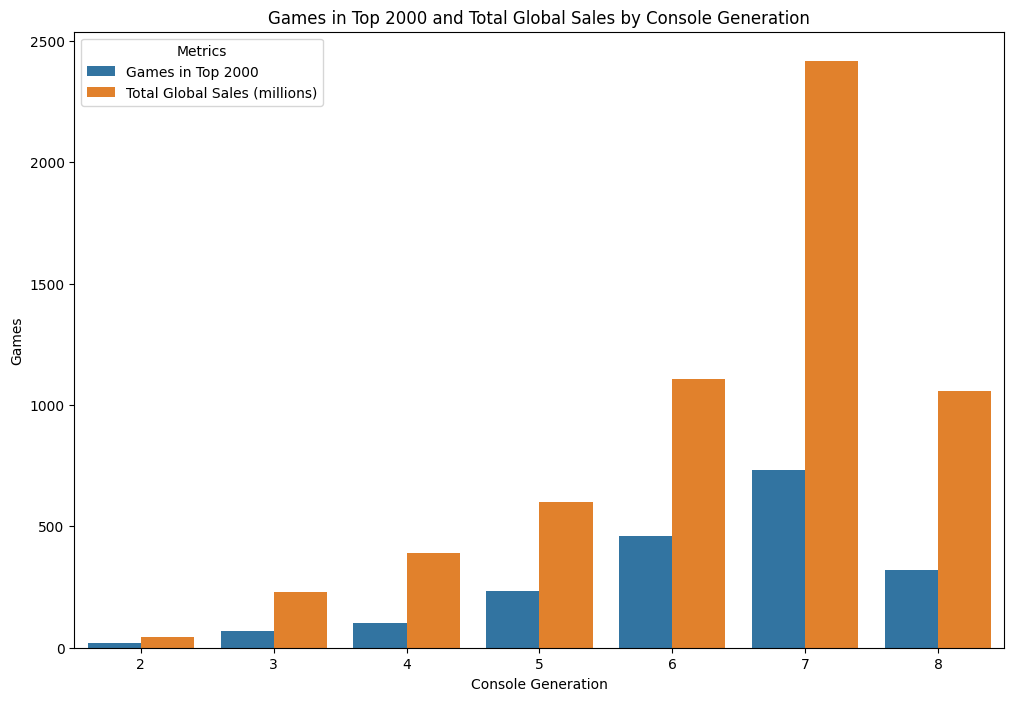

In [151]:
# Aggregate data
record_counts = df.groupby('ConsoleGeneration').size().reset_index(name='Games in Top 2000')
global_sales_sum = df.groupby('ConsoleGeneration')['Global_Sales'].sum().reset_index(name='Total Global Sales (millions)')

# Merge the two dataframes on ConsoleGeneration
merged_df = pd.merge(record_counts, global_sales_sum, on='ConsoleGeneration')

# Melt the dataframe to a long format for easy plotting with seaborn
melted_df = pd.melt(merged_df, id_vars=['ConsoleGeneration'], value_vars=['Games in Top 2000', 'Total Global Sales (millions)'])

# Create the side-by-side bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='ConsoleGeneration', y='value', hue='variable', data=melted_df)

# Set Title
plt.title('Games in Top 2000 and Total Global Sales by Console Generation')

# Set X-axis label
plt.xlabel('Console Generation')

# Set Y-labels
ax.set_ylabel('Games')

plt.legend(title='Metrics')
plt.show()

## Total Global Sales per Console Generation

# Plots